In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import copy
import scipy as sc

In [28]:
from scripts.QC.GT_matrices import Genotypes, Pedigree

 ### Load imputed Genotypes

In [29]:
home = "/Users/tilro532/dip_home/nas/stripes_AIL_gg6a/stripes2rqtl_bin500kb/"
initial_file = os.path.join(home, "F15","F15_gt_matrix_FilteredForBinsize500000.csv" )
gt = Genotypes(gt_file=initial_file, pedigree_file="/Users/tilro532/dip_home/nas/pedigree/AIL_pedigree_20190826.tsv")
gt.construct_density_bin_matrix(folder="/Users/tilro532/dip_home/nas/stripes_AIL_gg6a/")
gt.get_congruency_matrix()
gt.order_matrices()

In [ ]:
!head -1 {initial_file} | wc 

In [37]:
gt.gt_matrix.columns

Index(['1-1', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '1-17',
       ...
       '23-10', '23-11', '23-13', '24-1', '24-2', '24-5', '24-7', '24-8',
       '24-11', '24-14'],
      dtype='object', length=815)

 ### load GoldenGate markers

In [30]:
markers = pd.read_csv("./r_liftover/full_f15_markers_geno.csv", ).transpose()
markers.columns = markers.iloc[0].astype(int).astype(str)
markers = markers[1:]

In [41]:
positions = pd.read_csv("./r_liftover/new_positions_for_F15markers.csv")

In [39]:
markers = markers.replace(2, "A")
markers = markers.replace(1, "B")
markers = markers.replace(0, "C")


markers = markers.replace("A", 1)
markers = markers.replace("B", 0)
markers = markers.replace("C", -1)


In [43]:
positions = copy.deepcopy(positions[["seqnames", "start", "X"]])


In [44]:
positions.columns = ['chr', 'pos', 'marker']

In [45]:
positions.index = positions["marker"]
del(positions["marker"])

In [46]:
a = positions.merge(markers, how="inner", right_index=True, left_index=True)

### subset GGmarkers and stripesmarkers for Chromosome 1

In [47]:
a1 = a.loc[a["chr"]=="chr1"]

In [48]:
gt1 = gt.gt_matrix[[i for i in gt.gt_matrix.columns if i.startswith("1-")]]

In [49]:
len(gt1.columns)

162

In [50]:
#gt1.columns

Index(['1-1', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '1-17',
       ...
       '1-380', '1-381', '1-383', '1-385', '1-387', '1-389', '1-392', '1-393',
       '1-394', '1-395'],
      dtype='object', length=162)

### find intersection of Samples

In [51]:
all_samples_present_in_both = set.intersection(set(gt1.index),set(a1.columns))

In [52]:
len(all_samples_present_in_both)

777

In [53]:
len(gt1.columns)

162

In [54]:
print(gt1.columns)

Index(['1-1', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '1-17',
       ...
       '1-380', '1-381', '1-383', '1-385', '1-387', '1-389', '1-392', '1-393',
       '1-394', '1-395'],
      dtype='object', length=162)


In [ ]:
#a1

 ### bin markers according to position in MB

In [56]:
binsize = 500000
j = 0
d = {i:[]for i in range(395)}
for i,k in a1.iterrows():
    
    if (k["pos"]/binsize) > j:
        #print("position", k["pos"]/1000000)
        #print("position", k["pos"]//1000000)
        j = k["pos"]//binsize
        #print("is in", j)
        d[j].append(k[3:])
    

In [57]:
dd = {}
for key, item in d.items():
    #print(key)
    currbin= pd.DataFrame(item)
    if len(item) == 0:
        #print("len is 0, making empty array")
        mean = np.empty(824)
        mean.fill(np.nan)
    else:
        mean = currbin.mean(axis=0, skipna=True)
    dd[key] = mean    

In [58]:
binned_gt = pd.DataFrame.from_dict(dd)

In [59]:
#binned_gt

In [60]:
binned_gt.columns = ["1-"+str(i+1) for i in range(395)]

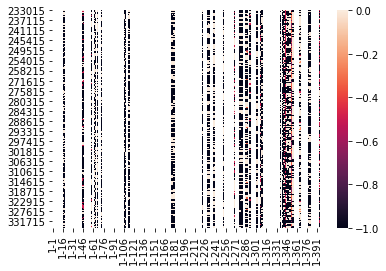

In [61]:
sns.heatmap(binned_gt)
plt.show()

In [62]:
binned_gt_marker_subset = binned_gt.transpose().dropna(how="all").transpose()

In [63]:
binned_gt_marker_subset["id"] =  binned_gt_marker_subset.index

In [64]:
binned_gt_marker_subset_lf = binned_gt_marker_subset.unstack().reset_index()

In [65]:
binned_gt_marker_subset_lf.columns = ["chr", "ID", "value"]

In [66]:
#a1_subset = a1.transpose().loc[list(all_samples_present_in_both)]

In [71]:
gt1_lf = gt1.unstack().reset_index()

In [68]:
#gt1_lf

In [72]:
gt1_lf.columns = ["chr", "ID", "value"]

In [73]:
gt1_lf.head()

,chr,ID,value
0,1-1,232915,0.0
1,1-1,233015,0.0
2,1-1,233115,1.0
3,1-1,233415,1.0
4,1-1,233515,0.0


In [74]:
merged = pd.merge(binned_gt_marker_subset_lf, gt1_f, how='inner', on=["chr", "ID"], left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_GG', '_stripes'), copy=True, indicator=False,
         validate=None)

In [76]:
mnona = merged.dropna()

In [78]:
cn = []
for i, k in merged.iterrows():
    if k["value_GG"]== k["value_stripes"]:
        cn.append(1)
    else:
        cn.append(0)
    

In [79]:
merged["same"] = cn

In [80]:
samples = merged.groupby("ID")
marker = merged.groupby("chr")

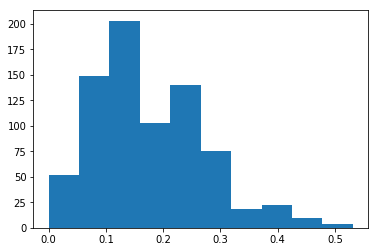

In [81]:
plt.hist(samples.mean()["same"])
plt.show()

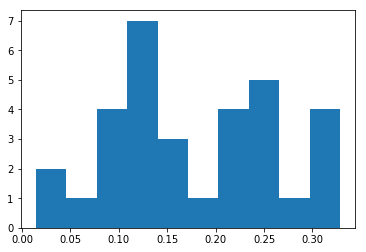

In [82]:
plt.hist(marker.mean()["same"])
plt.show()

In [ ]:
#for i, k, in d.items():
#    if len(k)>0:
#        print(len(k[0]))

In [83]:
len(binned_gt)

824

In [84]:
len(all_samples_present_in_both)

777

In [85]:
set_int = (set.intersection(set(binned_gt.index), set(all_samples_present_in_both)))

In [86]:
binned_gt_samples = binned_gt.loc[set_int].transpose().dropna(how="all").transpose()

In [87]:
gt1_samples = gt1.loc[set_int]

In [90]:
called_bins = list(set.intersection(set(binned_gt_samples.columns),set(gt1_samples.columns)))

In [91]:
gt1_samples_bins = gt1_samples[called_bins]

In [92]:
binned_gt_samples_bins = binned_gt_samples[called_bins]

In [93]:
def _order_bins(matrix):
    """
    take the columns ( i.e. bins) and order them logically.
    e.g. [1-1, 1-2, 1-3] instead of [1-1, 1-10, 1-11]
    """
    b=matrix
    bin_dict = {}
    for i in b:
        i = i.split("-")
        bin_dict.setdefault(int(i[0]),[]).append(int(i[1]))

    bin_list_ordered = []
    kl = list(bin_dict.keys())
    kl.sort()
    for key in kl:
        bin_dict[key].sort()
        for j in bin_dict[key]:
            bin_name = str(key)+"-"+str(j)
            bin_list_ordered.append(bin_name)
    return bin_list_ordered

In [94]:
ordered_cols = _order_bins(gt1_samples_bins)

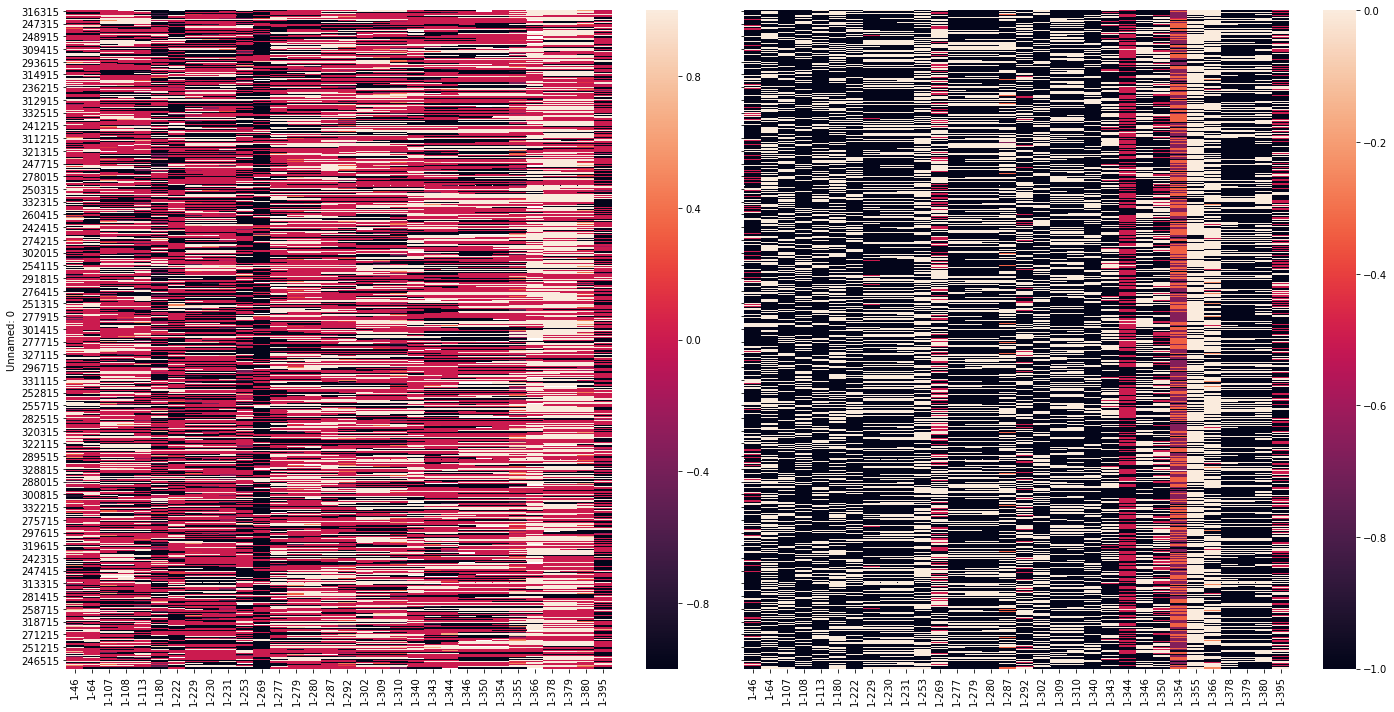

In [95]:
fig, (ax,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,10), sharex=True, sharey=True)
sns.heatmap(gt1_samples_bins[ordered_cols], ax=ax)
sns.heatmap(binned_gt_samples_bins[ordered_cols], ax=ax2)
plt.tight_layout()
plt.show()

In [96]:
cluster_by_imputed = sc.cluster.hierarchy.linkage(gt1_samples_bins[ordered_cols].dropna(),
                                           method="ward",
                                           metric='euclidean',
                                           optimal_ordering=True)

In [97]:
cluster_by_GG = sc.cluster.hierarchy.linkage(binned_gt_samples_bins[ordered_cols].dropna().loc[gt1_samples_bins[ordered_cols].dropna().index],
                                           method="ward",
                                           metric='euclidean',
                                           optimal_ordering=True)


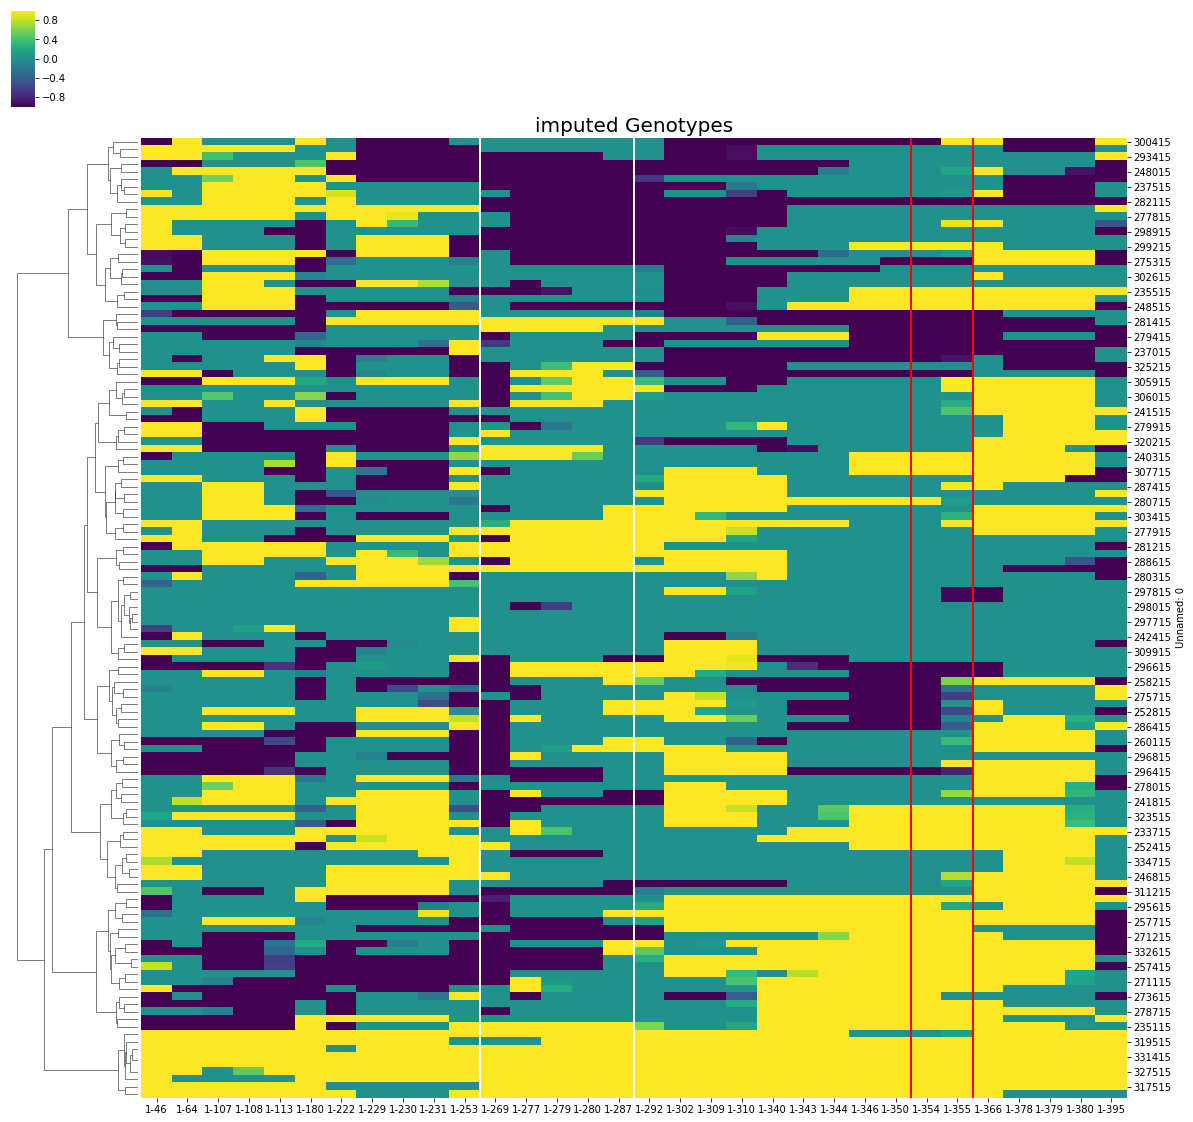

In [98]:
hm = sns.clustermap(gt1_samples_bins[ordered_cols].dropna(), col_cluster=False, row_linkage=cluster_by_imputed, cmap="viridis", figsize=(20,20))
ax = hm.ax_heatmap
ax.axvline(11, color="white", lw=2)
ax.axvline(16, color="white", lw=2)
#ax.axvline(18, color="white", lw=2)
ax.axvline(27, color="red", lw=2)
ax.axvline(25, color="red", lw=2)
ax.set_title("imputed Genotypes", size=20)
plt.show()

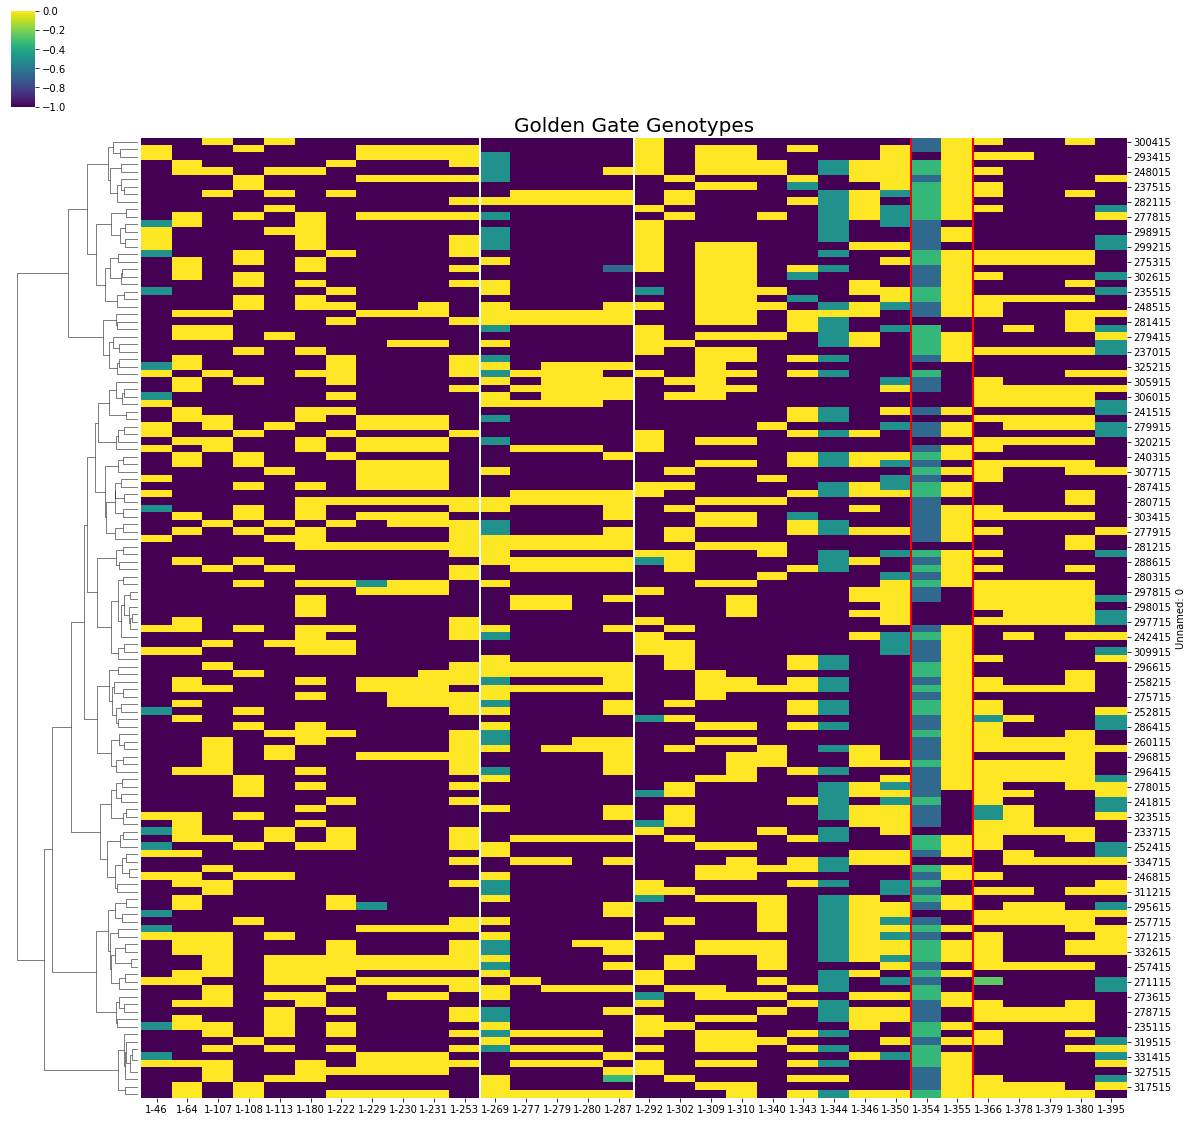

In [99]:
hm = sns.clustermap(binned_gt_samples_bins[ordered_cols].dropna().loc[gt1_samples_bins[ordered_cols].dropna().index], col_cluster=False,row_linkage=cluster_by_imputed,cmap="viridis", figsize=(20,20))
ax = hm.ax_heatmap
ax.axvline(11, color="white", lw=2)
ax.axvline(16, color="white", lw=2)
#ax.axvline(18, color="white", lw=2)
ax.axvline(27, color="red", lw=2)
ax.axvline(25, color="red", lw=2)
ax.set_title("Golden Gate Genotypes", size=20)

plt.show()

In [100]:
from scipy.stats.stats import pearsonr  
def get_r2_numpy_corrcoef(x, y):
    return np.corrcoef(x, y)[0, 1]**2

In [101]:
GG = binned_gt_samples_bins[ordered_cols].dropna().loc[gt1_samples_bins[ordered_cols].dropna().index]
ST = gt1_samples_bins[ordered_cols].dropna()

GGT = GG.transpose()
STT = ST.transpose()

In [102]:
pr = {}
for i , k in GGT.iterrows():
    #if len(Counter(k).values()) <= 3:
    #print(STT.loc[i])
    #print(pearsonr(k, STT.loc[i]))
    pr[i]=pearsonr(k, STT.loc[i])[0]
    #print(pearsonr(STT.loc[i], k))
    #print(get_r2_numpy_corrcoef(k, STT.loc[i]))

In [103]:
direction = {}
for key, item in pr.items():
    if item<0:
        direction[key] = -1
    else:
        direction[key] = 1

In [104]:
for i , k in GGT.iterrows():
    k = k*direction[i]

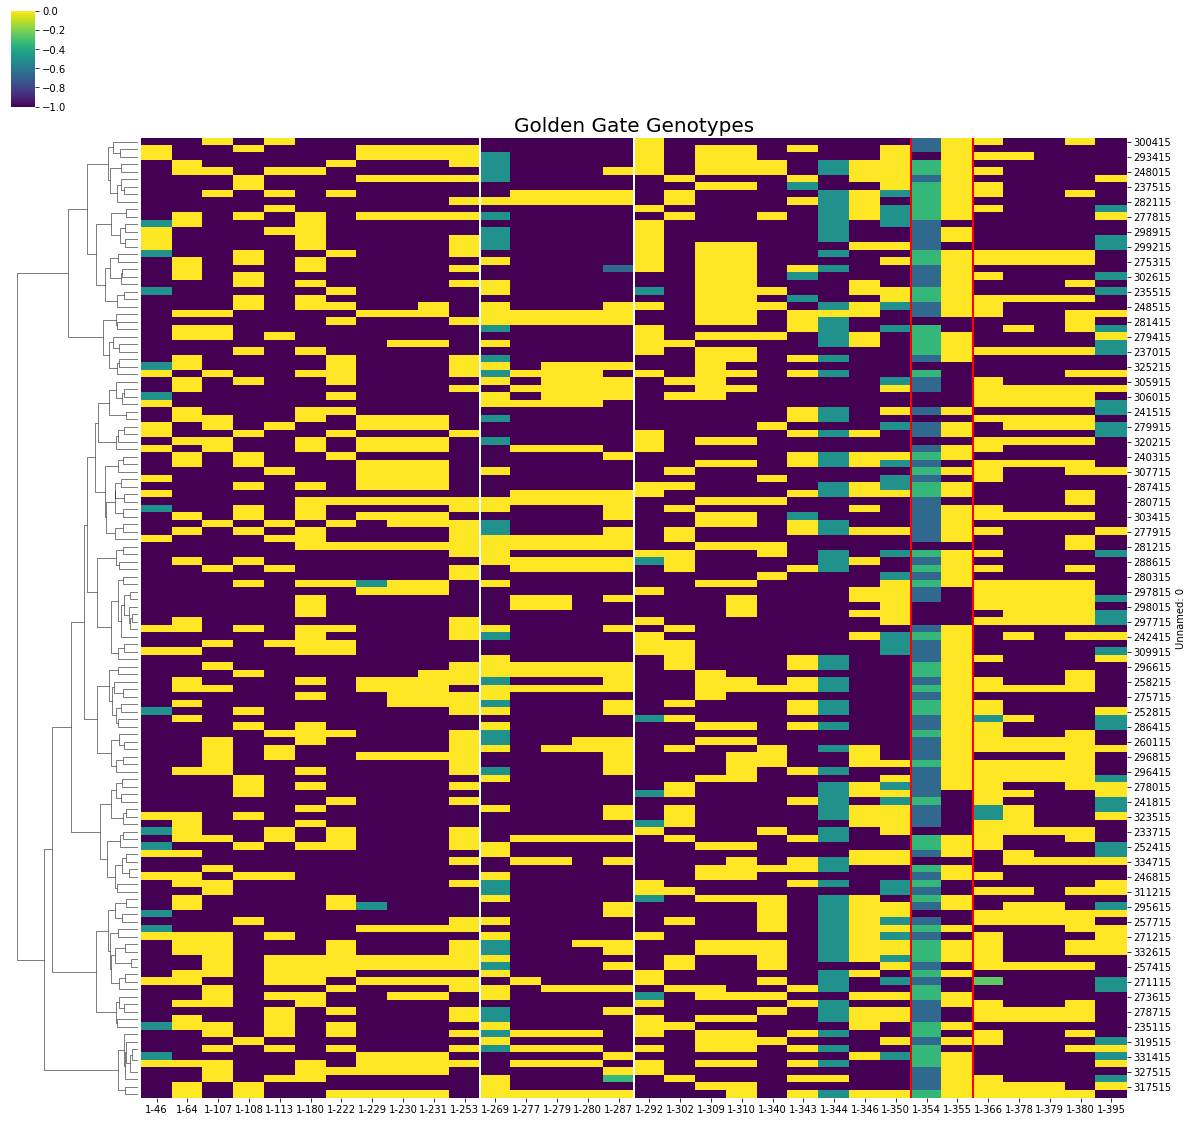

In [105]:
hm = sns.clustermap(GGT.transpose(), col_cluster=False,cmap="viridis", row_linkage=cluster_by_imputed, figsize=(20,20))
ax = hm.ax_heatmap
ax.axvline(11, color="white", lw=2)
ax.axvline(16, color="white", lw=2)
#ax.axvline(18, color="white", lw=2)
ax.axvline(27, color="red", lw=2)
ax.axvline(25, color="red", lw=2)
ax.set_title("Golden Gate Genotypes", size=20)

plt.show()

In [111]:
min(pr.values())

-0.5425008985013693

In [ ]:
GGT.loc["1-139"]

In [ ]:
STT.loc["1-139"]

In [ ]:
plt.scatter(STT.loc["1-139"], GGT.loc["1-139"], alpha=0.1)
plt.show()

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(30,10))
ax.plot(GGT.loc["1-139"], color="Red")
ax.plot(STT.loc["1-139"], color="Blue")
plt.show()

In [128]:
list(pr.values())
range(len(list(pr.values())))

range(0, 32)

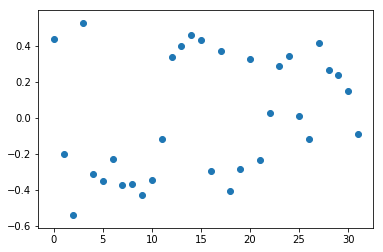

In [129]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(range(len(list(pr.values()))),list(pr.values()))
#ax.axhline(0.4, color="red")
#ax.axhline(-0.4, color="red")
plt.show()

(array([1., 6., 5., 3., 1., 2., 1., 3., 6., 4.]),
 array([-0.5425009 , -0.43541421, -0.32832752, -0.22124083, -0.11415415,
        -0.00706746,  0.10001923,  0.20710592,  0.31419261,  0.4212793 ,
         0.52836598]),
 <a list of 10 Patch objects>)

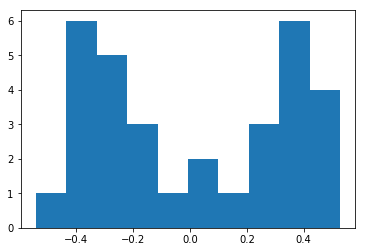

In [109]:
plt.hist(pr.values())